<a href="https://colab.research.google.com/github/dobrevajovana/Makedonizer/blob/main/NER_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 212 kB 47.1 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 38.9 MB/s 
     |████████████████████████████████| 134 kB 51.5 MB/s 
     |████████████████████████████████| 127 kB 48.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 47.6 MB/s 
     |████████████████████████████████| 144 kB 40.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 4.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import RobertaForTokenClassification, RobertaTokenizer

from datasets import load_dataset

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tqdm
tqdmn = tqdm.notebook.tqdm
%matplotlib inline

In [ ]:
tokenizer_path = '/content/drive/MyDrive/Macedonizer-Evaluation/mk-roberta-tokenizer'
model_path = '/content/drive/MyDrive/macedonizer.finki/mk-roberta-common-crawl/checkpoint-3800000'

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

In [ ]:
dataset = load_dataset("wikiann", 'mk')

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/mk/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
})

In [ ]:
dataset.shape

{'test': (1000, 4), 'train': (10000, 4), 'validation': (1000, 4)}

In [ ]:
dataset['train'][0]

{'langs': ['mk', 'mk', 'mk', 'mk', 'mk', 'mk', 'mk', 'mk', 'mk'],
 'ner_tags': [0, 0, 0, 3, 0, 1, 2, 0, 0],
 'spans': ['ORG: Шуцштафел', 'PER: Хајнрих Химлер'],
 'tokens': ['|Главниот',
  'заповедник',
  'на',
  'Шуцштафел',
  ',',
  'Хајнрих',
  'Химлер',
  'се',
  'самоубива']}

In [ ]:
num_labels = dataset['train'].features['ner_tags'].feature.num_classes

In [ ]:
MAX_LENGTH=128

In [ ]:
def add_encodings(example):
  """Processing the example

    Args:
        example (dict): The dataset example.

    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.

    """
  # get the encodings of the tokens. The tokens are already split, that is why we must add is_split_into_words=True
  encodings = tokenizer(example['tokens'], truncation=True, max_length=MAX_LENGTH, padding='max_length', is_split_into_words=True)
  # extend the ner_tags so that it matches the max_length of the input_ids

  labels = example['ner_tags']
  labels.extend([0] * MAX_LENGTH)
  labels = labels[:MAX_LENGTH]
  # labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
  # return the encodings and the extended ner_tags
  return { **encodings, 'labels': labels}

In [ ]:
# modify/format all datasets so that they include the 'input_ids', 'attention_mask'
# and 'labels' used to train and evaluate the model
dataset = dataset.map(add_encodings)

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

In [ ]:
assert len(dataset['train']['input_ids']) == len(dataset['train']['labels'])

In [ ]:
# format the datasets so that we return only 'input_ids', 'attention_mask' and 'labels'
# making it easier to train and validate the model
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
# get the NER labels and create two dictionaries for accessing their ids
labels = dataset['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [ ]:
id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [ ]:
label2id

{'B-LOC': 5,
 'B-ORG': 3,
 'B-PER': 1,
 'I-LOC': 6,
 'I-ORG': 4,
 'I-PER': 2,
 'O': 0}

In [ ]:
# initialize the model and provide the 'num_labels' used to create the classification layer
model = RobertaForTokenClassification.from_pretrained(model_path, num_labels=num_labels)
# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at /content/drive/MyDrive/macedonizer.finki/mk-roberta-common-crawl/checkpoint-3800000 were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/macedonizer.finki/mk-roberta-com

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# set the model in 'train' mode and send it to the device
model.to(device)
# initialize the Adam optimizer (used for training/updating the model)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-05)

In [ ]:
# set the number of epochs
n_epochs = 15
# batch the train data so that each batch contains 20 examples (using 'batch_size')
train_data = torch.utils.data.DataLoader(dataset['train'], batch_size=20)
# batch the train data so that each batch contains 16 examples (using 'batch_size')
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=16)

In [ ]:
def confusion_matrix(confusion):
  # Normalize by dividing every row by its sum
  for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

  fig, ax = plt.subplots(figsize=(10, 10))
  # visualize the loss values
  ax.matshow(confusion.numpy())

  # get the labels
  labels = list(label2id.keys())
  ids = np.arange(len(labels))

  ax.set_ylabel('True Labels', fontsize='x-large')
  ax.set_xlabel('Pred Labels', fontsize='x-large')

  # set the x ticks
  ax.set_xticks(ids)
  ax.set_xticklabels(labels)

  # set the y ticks
  ax.set_yticks(ids)
  ax.set_yticklabels(labels)

  # plot figure
  fig.tight_layout()
  plt.show()

In [ ]:
def eval(model):

  model.eval()

  confusion = torch.zeros(num_labels, num_labels)

  loss_val_total = 0
  predictions, true_vals = [], []
  # iterate through each batch of the train data
  for i, batch in enumerate(tqdmn(test_data)):
      # do not calculate the gradients
      with torch.no_grad():
          # move the batch tensors to the same device as the model
          batch = { k: v.to(device) for k, v in batch.items() }
          # send 'input_ids', 'attention_mask' and 'labels' to the model
          outputs = model(**batch)

      # get the sentence lengths
      s_lengths = batch['attention_mask'].sum(dim=1)
      loss_val_total += outputs[0].item()
      # iterate through the examples
      for idx, length in enumerate(s_lengths):
          # get the true values
          true_values = batch['labels'][idx][:length]
          # get the predicted values
          pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]

          predictions.append(pred_values.detach().cpu().numpy())
          true_vals.append(true_values.detach().cpu().numpy())
          # go through all true and predicted values and store them in the confusion matrix
          for true, pred in zip(true_values, pred_values):
              confusion[true.item()][pred.item()] += 1

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
  loss_val_avg = loss_val_total/len(test_data)

  return true_vals, predictions, loss_val_avg, confusion

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.8129101505279541


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.5386468739736647
F1 Score: 0.8068177136846169
Accuracy Score: 0.8510036373433921
Precision Score: 0.820883031476098
Recall Score: 0.8510036373433921
MCC Score: 0.4091137239503251


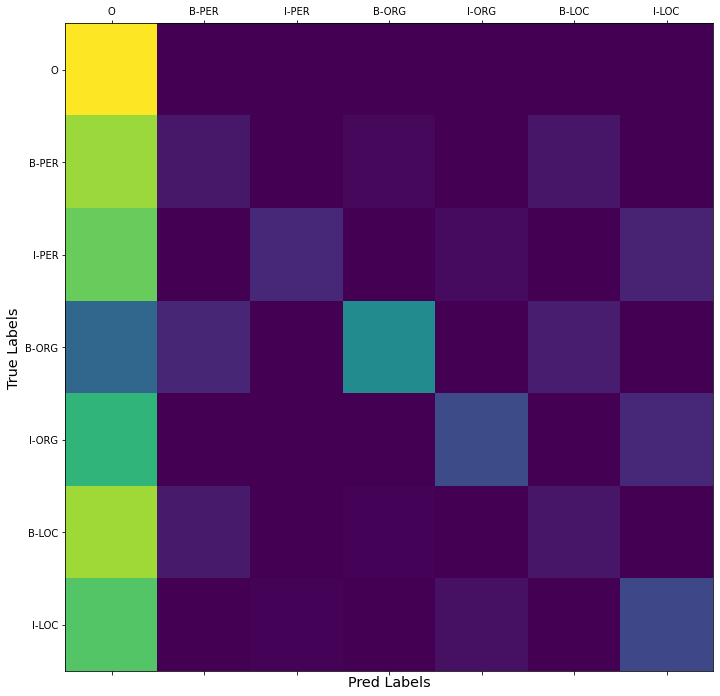

Epoch: 2


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.4873331040740013


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.39389276126074413
F1 Score: 0.8609855299270042
Accuracy Score: 0.881045399434191
Precision Score: 0.8648379998299605
Recall Score: 0.881045399434191
MCC Score: 0.5737405801142427


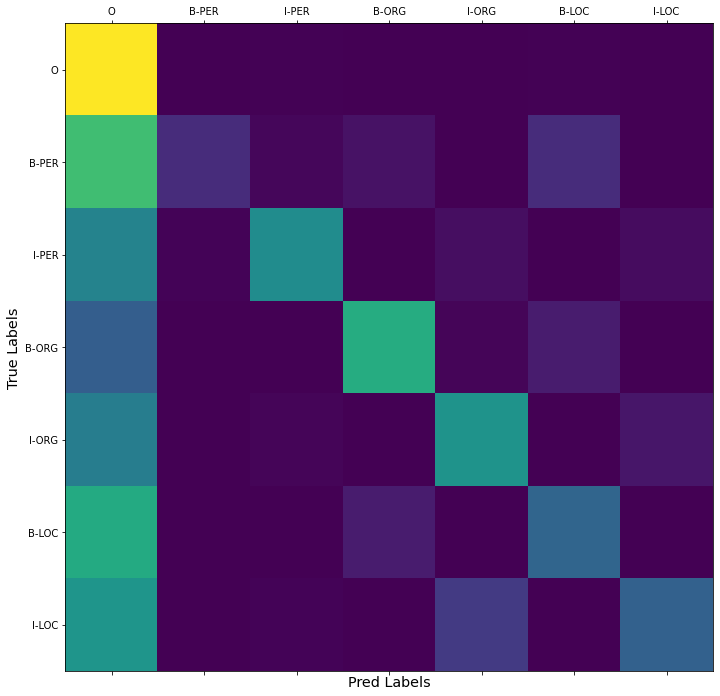

Epoch: 3


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.3677095562815666


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.29806102268279544
F1 Score: 0.8996007369534459
Accuracy Score: 0.905294355381921
Precision Score: 0.8984531027412935
Recall Score: 0.905294355381921
MCC Score: 0.6860558374193667


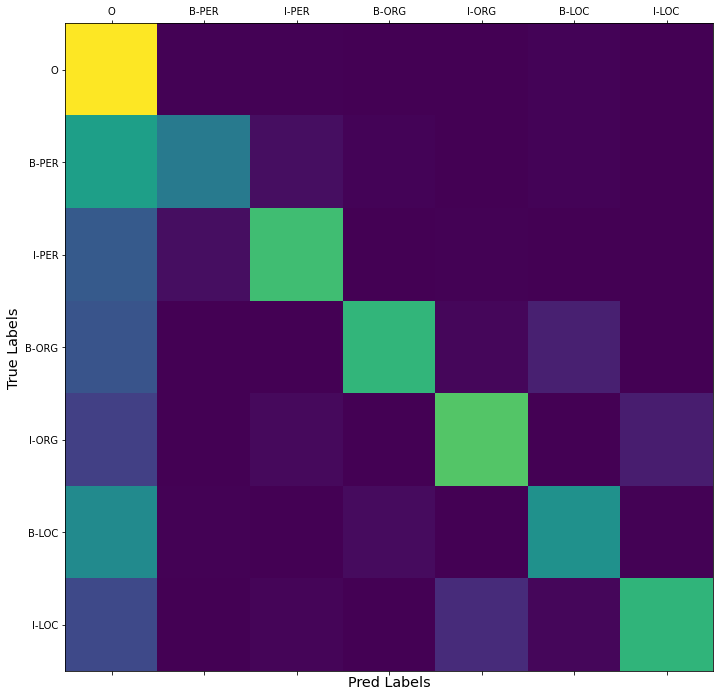

Epoch: 4


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.293522367477417


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.24978000516929325
F1 Score: 0.9144042504229574
Accuracy Score: 0.9171494005119224
Precision Score: 0.9134097599691441
Recall Score: 0.9171494005119224
MCC Score: 0.7341892528742764


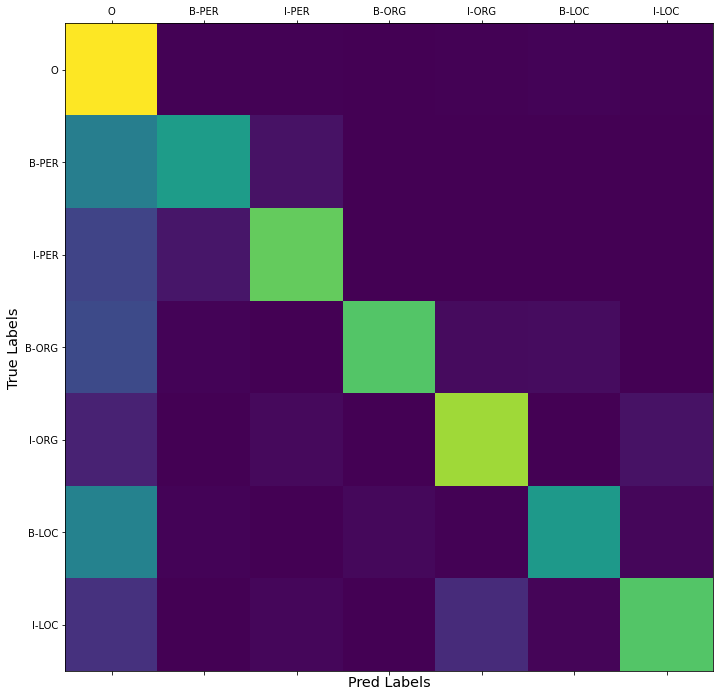

Epoch: 5


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.24750095665454863


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.22091306970706062
F1 Score: 0.920882733966664
Accuracy Score: 0.9230095648659572
Precision Score: 0.9198142560953046
Recall Score: 0.9230095648659572
MCC Score: 0.7551953326195344


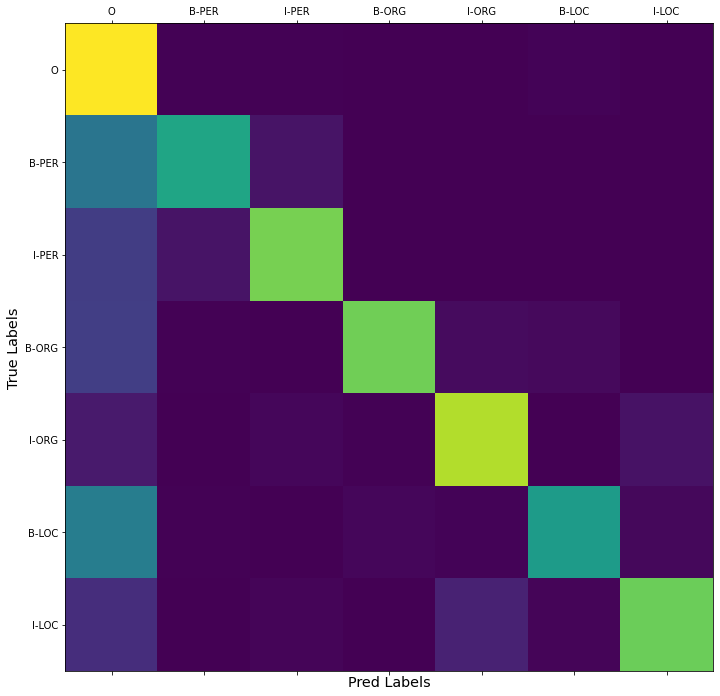

Epoch: 6


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.21889077661931514


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.20332054876618916
F1 Score: 0.9255868661095067
Accuracy Score: 0.9273204903677759
Precision Score: 0.9246312425960834
Recall Score: 0.9273204903677759
MCC Score: 0.7704982318653649


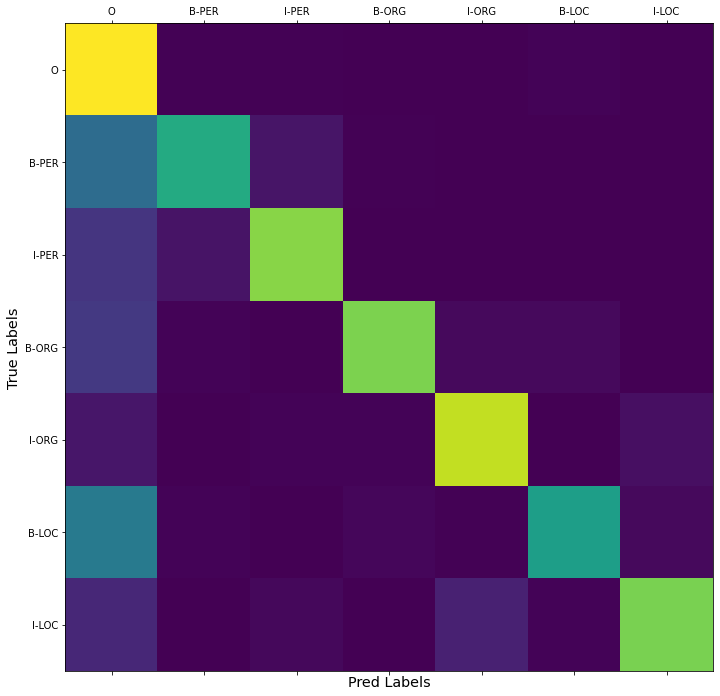

Epoch: 7


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.1982040097117424


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.19204410709558972
F1 Score: 0.927651965322883
Accuracy Score: 0.9290718038528897
Precision Score: 0.9269396713364723
Recall Score: 0.9290718038528897
MCC Score: 0.7773044247325281


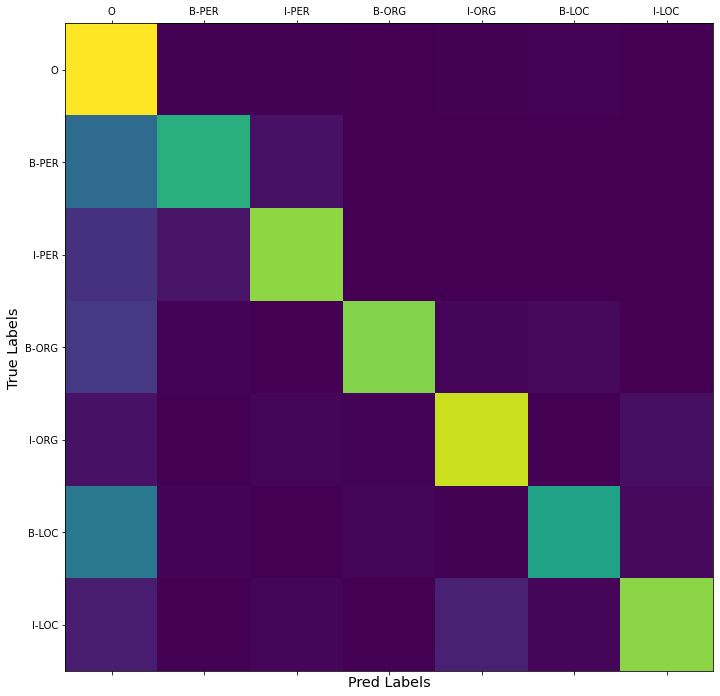

Epoch: 8


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.18064747427403927


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.1820057915553214
F1 Score: 0.9304288782596873
Accuracy Score: 0.9318334905024922
Precision Score: 0.9296706872679795
Recall Score: 0.9318334905024922
MCC Score: 0.7862658559598725


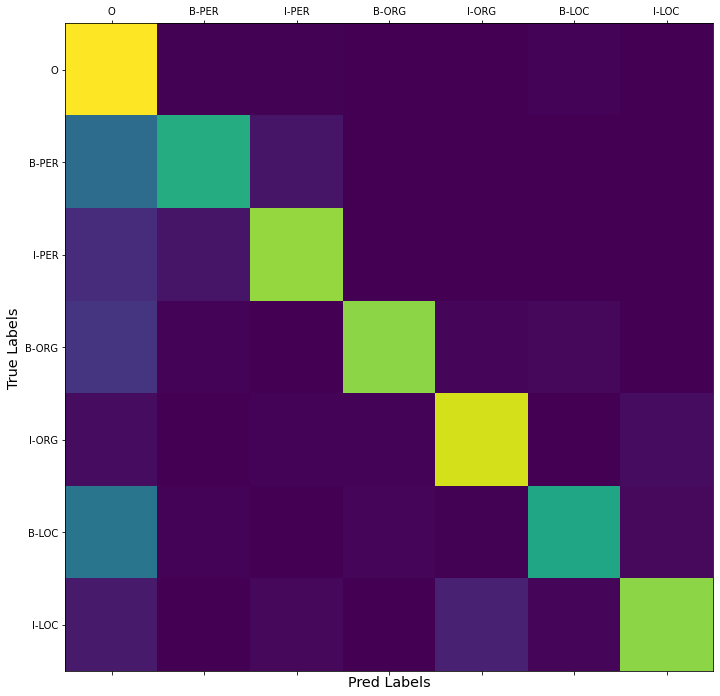

Epoch: 9


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.16646914701908827


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.1756174603388423
F1 Score: 0.932397012663281
Accuracy Score: 0.9337868786205038
Precision Score: 0.9321560978363411
Recall Score: 0.9337868786205038
MCC Score: 0.7929132609701132


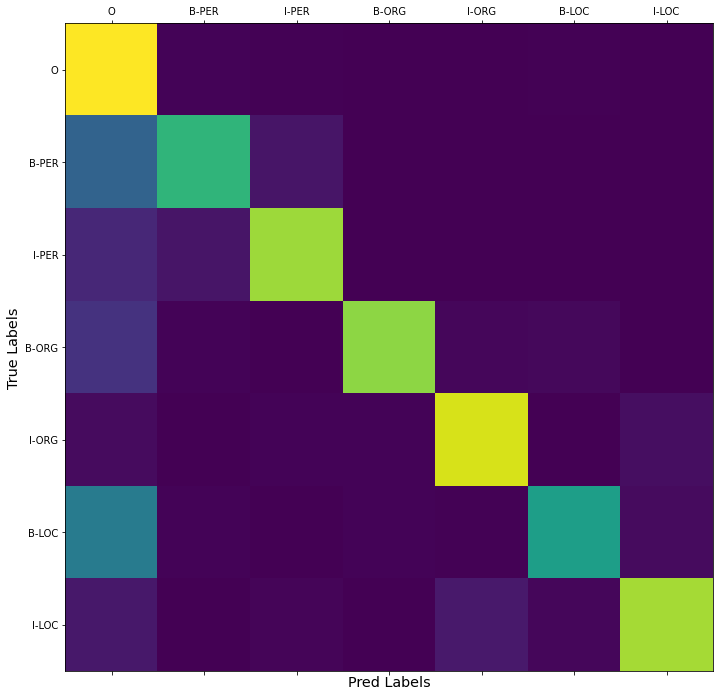

Epoch: 10


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.15168899424374105


  0%|          | 0/63 [00:00<?, ?it/s]

Validation loss: 0.1692076033897816
F1 Score: 0.9349603722274359
Accuracy Score: 0.9358749831604473
Precision Score: 0.9346322555247967
Recall Score: 0.9358749831604473
MCC Score: 0.8005800831542428


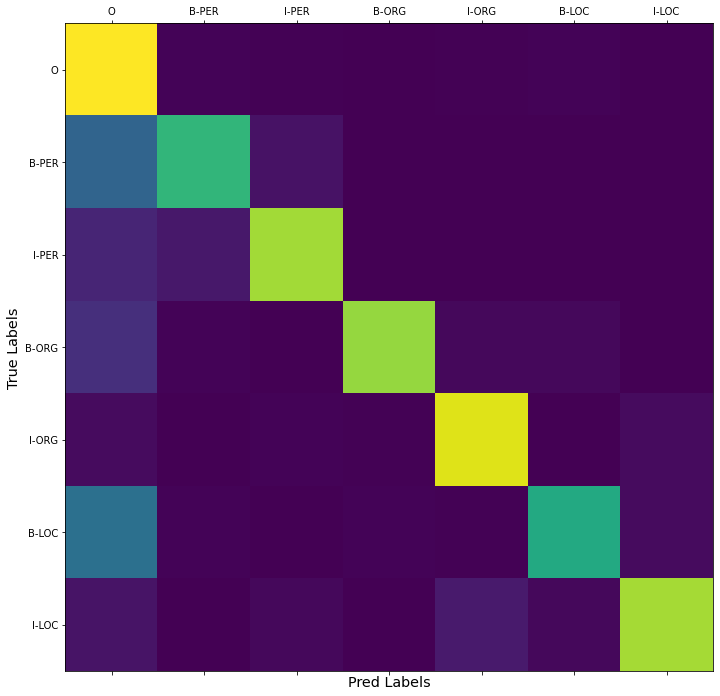

Epoch: 11


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
train_loss = []
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs)):
  print(f"Epoch: {epoch + 1}")
  model.train()
  current_loss = 0
  overall_loss = 0
  # iterate through each batch of the train data
  for i, batch in enumerate(tqdmn(train_data)):
    # move the batch tensors to the same device as the
    batch = { k: v.to(device) for k, v in batch.items() }
    # send 'input_ids', 'attention_mask' and 'labels' to the model
    outputs = model(**batch)
    # the outputs are of shape (loss, logits)
    loss = outputs[0]
    # with the .backward method it calculates all
    # of  the gradients used for autograd
    loss.backward()

    current_loss += loss.item()
    overall_loss += loss.item()
    if i % 8 == 0 and i > 0:
        # update the model using the optimizer
        optimizer.step()
        # once we update the model we set the gradients to zero
        optimizer.zero_grad()
        # store the loss value for visualization
        train_loss.append(current_loss / 32)
        current_loss = 0
  # update the model one last time for this epoch
  optimizer.step()
  optimizer.zero_grad()
  print(f"Training loss: {overall_loss/len(train_data)}")

  # evaluate the model
  pred = eval(model)
  print(f"Validation loss: {pred[2]}")
  print(f"F1 Score: {f1_score(pred[0], pred[1], average='weighted')}")
  print(f"Accuracy Score: {accuracy_score(pred[0], pred[1])}")
  print(f"Precision Score: {precision_score(pred[0], pred[1], average='weighted')}")
  print(f"Recall Score: {recall_score(pred[0], pred[1], average='weighted')}")
  print(f"MCC Score: {matthews_corrcoef(pred[0], pred[1])}")
  confusion_matrix(pred[3])
  # print(f'ROC AUC: {roc_auc_score(pred[0], pred[1], average='weighted')}')

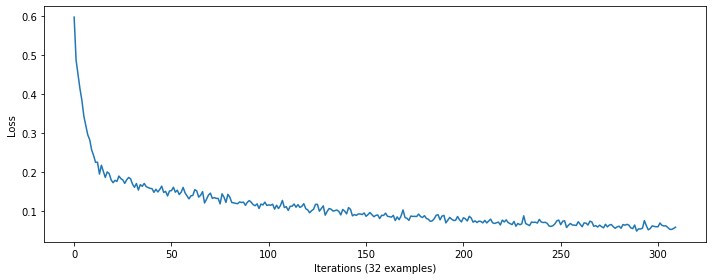

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 4))
# # visualize the loss values
# ax.plot(train_loss)
# # set the labels
# ax.set_ylabel('Loss')
# ax.set_xlabel('Iterations (32 examples)')
# fig.tight_layout()
# plt.show()